# Deep learning basics: a less simple classification case
In this tutorial, we push the classification case a bit further. We train a Multi Layer Perceptron (MLP) on a multi-class classification task. Our goal is to determine to which quadrant of the Cartesian grid do the points belong based on their coordinates.

## Step 1: Prepare the environment

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import IntSlider, interact
%matplotlib nbagg

In [ ]:
# Define computing device
use_cuda = False

if torch.cuda.is_available and use_cuda:
    print('We have GPU !')
    device = torch.device('cuda')
else:
    print('We will use CPU')
    device = torch.device('cpu')

In [ ]:
# Fix random seed for reproducibility
torch.manual_seed(0)

## Step 2: Generate training data

In [ ]:
# Training data
num_classes = 4
radius = torch.rand(1000)
angle = torch.rand(1000) * 2 * np.pi
x_1 = radius * torch.cos(angle)
x_2 = radius * torch.sin(angle)
inputs = torch.stack((x_1, x_2), dim=1).to(device)
# Label
labels = (angle / (2 * np.pi) * num_classes).floor()
labels = labels.type(torch.LongTensor).to(device)

In [ ]:
plt.figure()
ax_data = plt.gca()
ax_data.scatter(inputs[:, 0], inputs[:, 1], c=labels, s=3, cmap=ListedColormap(['orange', 'green', 'blue', 'red']))
ax_data.axhline(y=0, color='k', lw=0.5)
ax_data.axvline(x=0, color='k', lw=0.5)
plt.axis('equal')
plt.title('Training data')

## Step 3: Build the neural network

We build a MLP, i.e., composed of Fully Connected layers, with **2 hidden layers**. Notice that the **last neuronal layer has no activation function** (or the identity as an activation). Instead, a final **Softmax function** transforms the model output into a probability to belong to each class.

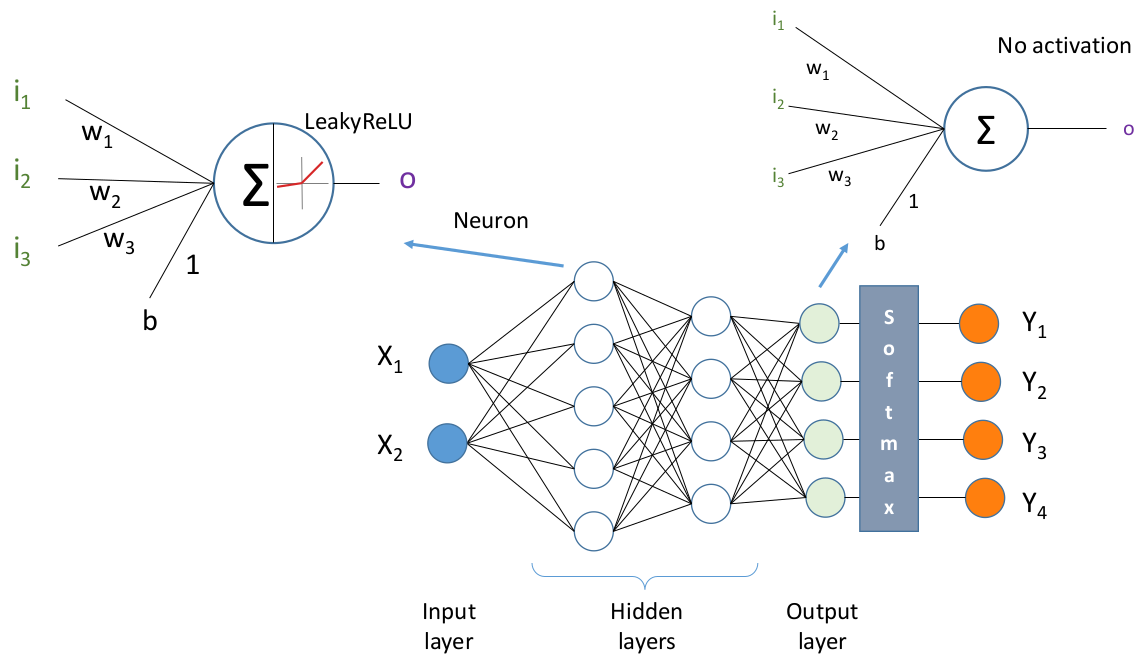

### Exercises
1. Complete the definition of the following neural network. Fill the missing code and set the number of neurons of each layer.
2. Find a suitable learning rate.
2. If you still have time, find the minimal number of neurons for each layer offering satisfying performance on the task we're trying to solve, 
    i.e., test accuracy > 0.98.
4. You still have time ? Play with the learning rate scheduler to observe its effect on the evolution of the loss and on the performance.

In [ ]:
neurons_lin1 = ?
neurons_lin2 = ?

model = torch.nn.Sequential(
    # hidden layers
    ?
    
    
    # output layers
    torch.nn.Linear(in_features= ? , out_features=num_classes),
)

model.to(device)

## Step 4: Define training hyperparameters

In [ ]:
# Loss function
criterion = torch.nn.CrossEntropyLoss()  # Includes a LogSoftmax and the NegativeLogLikelihood loss

In [ ]:
learning_rate = 0.002

In [ ]:
# Optimizer (Gradient descent)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Optional: add a scheduler and play with the parameters
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 50

## Step 5: Train the network

In [ ]:
predictions = []
losses = []

for epoch in range(num_epochs):
    # Reinitialize gradient of the model weights
    optimizer.zero_grad()
    
    # Prediction
    y_pred = model(inputs)
    
    # Error measurement
    loss = criterion(y_pred, labels)
    
    # Backpropagation
    loss.backward()
    
    # Weight update
    optimizer.step()
    # Optional: add a scheduler
    # scheduler.step()
    
    predictions.append(y_pred.detach().to('cpu'))
    losses.append(loss.detach().to('cpu'))

### Training results

In [ ]:
plt.figure(figsize=(4,3))
plt.xlabel('Epoch')
plt.title('Training loss')
plt.plot(losses)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots()
pred = torch.argmax(predictions[0], dim=1)
ax.scatter(inputs[:, 0].to('cpu'), inputs[:, 1].to('cpu'), c=pred, 
           s=3, cmap=ListedColormap(['orange', 'green', 'blue', 'red']))
ax.axhline(y=0, color='k', lw=0.5)
ax.axvline(x=0, color='k', lw=0.5)

ax.axis('equal')
ax.set_title('Prediction on training data')

@interact(epoch=IntSlider(min=0, max=num_epochs-1, step=5, value=0))
def update(epoch=0):
    pred_epoch = torch.argmax(predictions[epoch], dim=1)
    for path_collection in ax.collections:
        path_collection.remove()
    ax.scatter(inputs[:, 0].to('cpu'), inputs[:, 1].to('cpu'), c=pred_epoch, 
           s=3, cmap=ListedColormap(['orange', 'green', 'blue', 'red']))
    accuracy = (pred_epoch == labels).float().mean()
    print('Loss: {:0.4f}'.format(losses[epoch]))
    print('Accuracy: {:0.3f}'.format(accuracy))
    fig.canvas.draw()

## Step 6: Test the model on new data

In [ ]:
# Test data
radius_test = torch.rand(1000)
angle_test = torch.rand(1000) * 2 * np.pi
x_1_test = radius_test * torch.cos(angle_test)
x_2_test = radius_test * torch.sin(angle_test)
inputs_test = torch.stack((x_1_test, x_2_test), dim=1).to(device)
# Label
labels_test = (angle_test / (2 * np.pi) * num_classes).floor()
labels_test = labels_test.type(torch.LongTensor).to(device)

In [ ]:
# Switch the model to test mode
# This is important for some kinds of layers, such as BatchNorm, that have 
# different behavior at test and training time
model.eval()

# We don't need to build the gradient graph, so let's save some memory !
with torch.no_grad():
    y_pred_test = model(inputs_test)
    test_loss = criterion(y_pred_test, labels_test)

In [ ]:
fig_test, ax_test = plt.subplots()

pred_test = torch.argmax(y_pred_test, dim=1)
ax_test.scatter(inputs_test[:, 0].to('cpu'), inputs_test[:, 1].to('cpu'), c=pred_test, 
                       s=5, cmap=ListedColormap(['orange', 'green', 'blue', 'red']))
ax_test.axhline(y=0, color='k', lw=0.5)
ax_test.axvline(x=0, color='k', lw=0.5)

ax_test.axis('equal')
ax_test.annotate(text='Test Loss: {:0.4f}'.format(test_loss),  xy=(0.6, -0.9))

accuracy_test = (y_pred_test.argmax(dim=1) == labels_test).float().mean()
ax_test.annotate(text='Test Acc: {:0.4f}'.format(accuracy_test),  xy=(0.6, -1))

ax_test.set_title('Prediction on test data')


## Do you need a "solution" ?
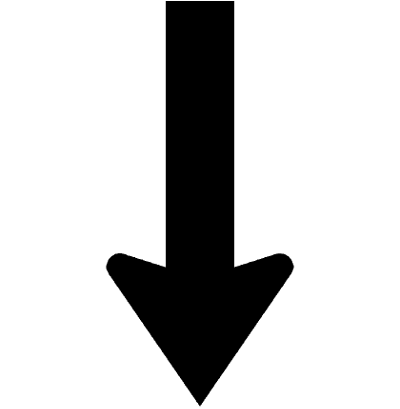

### Hints

* The model definition is quite similar to the previous tutorials.
* You can explore learning rates in the range [0.05 ; 0.5]
* For the parametrization of the scheduler, observe the training loss evolution to set the step_size

### Solution
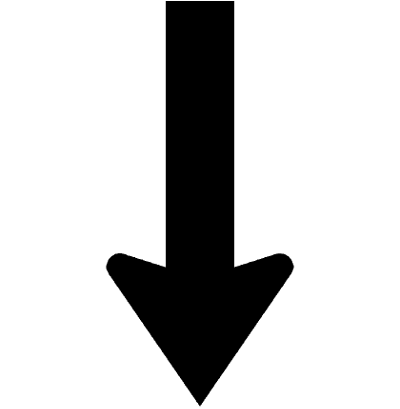

In [ ]:
neurons_lin1 = 12
neurons_lin2 = 6

model = torch.nn.Sequential(
    # hidden layers
    torch.nn.Linear(in_features=inputs.shape[1], out_features=neurons_lin1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(in_features=neurons_lin1, out_features=neurons_lin2),
    torch.nn.LeakyReLU(),
    # output layers
    torch.nn.Linear(in_features=neurons_lin2, out_features=num_classes),
)

learning_rate = 0.2